#### To run go to: https://www.kaggle.com/code/nikhileshmyanapuri/sleep-staging

In [6]:
!pip install pyedflib

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from scipy import signal
import matplotlib.pyplot as plt
# import pyedflib
import pywt
from tqdm import tqdm
from matplotlib import colormaps
from sklearn.preprocessing import OneHotEncoder
from skimage.transform import resize
import torch
import torch.nn as nn
import torch.nn.functional as F
# from PIL import Image
# from io import BytesIO


2024-03-02 13:36:29.663592: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-02 13:36:29.663686: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-02 13:36:29.792392: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [8]:

# # detect and init the TPU
# tpu = tf.distribute.cluster_resolver.TPUClusterResolver()

# # instantiate a distribution strategy
# tf.tpu.experimental.initialize_tpu_system(tpu)
# tpu_strategy = tf.distribute.TPUStrategy(tpu)


In [9]:
# Define the notch filter parameters
fs = 200  # Sample rate (Hz)
f0 = 50  # Powerline frequency to be eliminated (Hz)
Q = 30  # Quality factor

# Create the notch filter
b, a = signal.iirnotch(f0, Q, fs)

# Define the Butterworth filter parameters
fs = 200  # Sample rate (Hz)
lowcut = 0.3  # Lower cutoff frequency (Hz)
highcut = 30  # Higher cutoff frequency (Hz)
order = 2  # Filter order

# Calculate the normalized cutoff frequencies
nyquist = 0.5 * fs
low = lowcut / nyquist
high = highcut / nyquist

# Create the Butterworth filter
b, a = signal.butter(order, [low, high], btype='band')

cmap = colormaps.get_cmap('jet')  # Choose your desired colormap



In [6]:
sig_labels = pd.read_excel(f"/kaggle/input/isruc-sleep-data/target_data/1_1.xlsx")
sig_labels = sig_labels['Stage'][:-30]
print(sig_labels.unique())
# all_subj_labels = pd.get_dummies(sig_labels).to_numpy() 
enc = OneHotEncoder(handle_unknown='ignore')
all_subj_labels = enc.fit_transform(sig_labels.to_numpy().reshape(-1,1)).toarray()
for i in range(99):
    sig_labels = pd.read_excel(f"/kaggle/input/isruc-sleep-data/target_data/{i+2}_1.xlsx")
    sig_labels = sig_labels.iloc[:,1][:-30].replace("N","N1")
#     sig_labels = sig_labels.dropna()
    print(sig_labels.unique())
#     print(sig_labels[sig_labels.isna()].index)
    enc_labels = enc.transform(sig_labels.to_numpy().reshape(-1,1)).toarray()
    all_subj_labels = np.append(all_subj_labels, enc_labels, 0)
np.savetxt("all_subj_labels.csv",all_subj_labels,delimiter=",")

['W' 'N1' 'N2' 'N3' 'R']
['W' 'N1' 'N2' 'N3' 'R']
['W' 'N1' 'N2' 'N3' 'R']
['W' 'N1' 'N2' 'N3' 'R']
['W' 'N1' 'N2' 'N3' 'R']
['W' 'N1' 'N2' 'N3']
['W' 'N1' 'N2' 'R' 'N3']
['W' 'N1' 'N2' 'N3' 'R']
['W' 'N1' 'N2' 'N3' 'R']
['W' 'N1' 'N2' 'N3' 'R']
['W' 'N1' 'N2' 'N3' 'R']
['W' 'N1' 'N2' 'N3' 'R' 'U']
['W' 'N1' 'N2' 'N3' 'R' 'U']
['W' 'N1' 'N2' 'N3' 'R']
['W' 'N1' 'N2' 'N3' 'R']
['W' 'N1' 'N2' 'N3' 'R']
['W' 'N1' 'N2' 'N3' 'R']
['W' 'N1' 'N2' 'N3' 'R']
['W' 'N1' 'N2' 'N3' 'R']
['W' 'N1' 'N2' 'N3' 'R']
['W' 'N1' 'N2' 'R' 'N3']
['W' 'N1' 'N2' 'N3' 'R']
['W' 'N1' 'N2' 'N3' 'R']
['W' 'N1' 'N2' 'N3' 'R']
['W' 'N1' 'N2' 'N3' 'R']
['W' 'N1' 'N2' 'R' 'N3']
['W' 'N1' 'N2' 'N3' 'R']
['W' 'N1' 'N2' 'N3' 'R']
['W' 'N1' 'N2' 'N3' 'R']
['W' 'N1' 'N2' 'N3' 'R']
['W' 'N1' 'N2' 'N3' 'R']
['W' 'N1' 'N2' 'N3' 'R']
['W' 'N1' 'N2' 'N3' 'R']
['W' 'N1' 'N2' 'N3' 'R']
['W' 'N1' 'N2' 'N3' 'R']
['W' 'N1' 'N2' 'N3' 'R']
['U' 'W' 'N1' 'N2' 'N3' 'R']
['W' 'N1' 'N2' 'N3' 'R']
['W' 'N1' 'N2' 'N3' 'R']
['W' 'N1' 'N2' 'N

In [11]:
all_subj_labels.shape

(87249, 5)

In [ ]:
for k in range(9,10):
    all_subj = []
    for i in range(10*k,10*(k+1)):
        print(f"Subject_{i+1}")
        # Open the .rec file
        f = pyedflib.EdfReader(f"/kaggle/input/isruc-sleep-data/raw_data/{i+1}.rec")

        # # Get the number of signals in the .rec file
        # num_signals = f.signals_in_file
        # # Get the signal labels
        # signal_labels = f.getSignalLabels()

        # # Read the signals
        input_signal = f.readSignal(6)

        # Close the .rec file
        f.close()

        sig_labels = pd.read_excel(f"/kaggle/input/isruc-sleep-data/target_data/{i+1}_1.xlsx")
        sig_labels = sig_labels.iloc[:,1][:-30]
    #     sig_labels = sig_labels.dropna()
    #     enc_labels = pd.get_dummies(sig_labels).to_numpy() 

    #     sig_epochs = []
        for j in tqdm(range(len(sig_labels))):
            sig = input_signal[6000*j:6000*(j+1)]
            # Apply the notch filter to the signal
            notch_filtered_signal = signal.lfilter(b, a, sig)
            # Apply the filter to the signal
            filtered_signal = signal.lfilter(b, a, notch_filtered_signal)
            # Performing Continuous Wavelet Transform
            cfs, f = pywt.cwt(sig, np.arange(1,98), 'morl')
            # Plot the Continuous Wavelet Transform
            # plt.imshow(abs(cfs), aspect='auto', cmap='jet')
            # plt.axis('off')

            # # Use BytesIO to capture the plot data in memory
            # buffer = BytesIO()
            # plt.savefig(buffer, format='png', bbox_inches='tight')

            # # Load the plot data from the buffer into a NumPy array
            # np_img = np.array(Image.open(buffer))
            abs_cfs = np.abs(cfs)
            norm = plt.Normalize(abs_cfs.min(), abs_cfs.max())
            rgb_array = cmap(norm(abs_cfs))[:, :, :3]  # Efficiently select RGB channels
            resized_rgb_array = resize(rgb_array, (64,64,3), anti_aliasing=True)
    #         sig_epochs.append(resized_rgb_array)
            all_subj.append(resized_rgb_array)

            # Close the buffer (optional)
            # buffer.close()
            # print(j)
    #     sig_epochs = np.array(sig_epochs)
    #     all_subj.extend(sig_epochs)
    #     print('Train the model')
        # Train the model
    #     model.fit(sig_epochs, enc_labels, batch_size= 32, epochs=20)

    all_subj = np.array(all_subj)
    np.save(f'all_subj_imgs_{k}',all_subj)

Subject_91


100%|██████████| 960/960 [09:54<00:00,  1.62it/s]


Subject_92


100%|██████████| 847/847 [08:45<00:00,  1.61it/s]


Subject_93


100%|██████████| 840/840 [08:47<00:00,  1.59it/s]


Subject_94


100%|██████████| 816/816 [08:31<00:00,  1.60it/s]


Subject_95


100%|██████████| 835/835 [08:37<00:00,  1.61it/s]


Subject_96


100%|██████████| 828/828 [08:30<00:00,  1.62it/s]


Subject_97


100%|██████████| 882/882 [09:05<00:00,  1.62it/s]


Subject_98


  1%|▏         | 11/869 [00:06<08:48,  1.62it/s]

In [2]:
train_subj = np.load(f"/kaggle/input/isruc-cwt-images-dataset/all_subj_imgs_0.npy")
for i in range(1,10):
    subj_img = np.load(f"/kaggle/input/isruc-cwt-images-dataset/all_subj_imgs_{i}.npy")
    train_subj = np.append(train_subj,subj_img,axis=0)
    
train_labels = np.loadtxt("/kaggle/input/isruc-cwt-images-dataset/all_subj_labels (3).csv",delimiter=",",dtype=float)
train_subj.shape,train_labels.shape

((87249, 64, 64, 3), (87249, 5))

In [12]:
# from torch.utils.data import DataLoader, TensorDataset

# # Convert numpy arrays to PyTorch tensors
# train_data_tensor = torch.tensor(train_subj, dtype=torch.float32)
# train_labels_tensor = torch.tensor(train_labels, dtype=torch.long)


# # Create a DataLoader
# train_loader = DataLoader(TensorDataset(train_data_tensor, train_labels_tensor), batch_size=128)

In [3]:
train_labels = np.argmax(train_labels,axis=1)
train_labels.shape

(87249,)

In [4]:
# instantiating the model in the strategy scope creates the model on the TPU
# with tpu_strategy.scope(): 
initializer = tf.keras.initializers.GlorotUniform(seed=0)
model = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=(64, 64, 3)),
    tf.keras.layers.Conv2D(128, (7, 7), activation='relu',kernel_initializer=initializer),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.MaxPooling2D((3, 3), strides=(2, 2)),
    tf.keras.layers.Conv2D(64, (5, 5), activation='relu',kernel_initializer=initializer),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.MaxPooling2D((3, 3), strides=(2, 2)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu',kernel_initializer=initializer),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.MaxPooling2D((2, 2), strides=(2, 2)),
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu',kernel_initializer=initializer),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(5,activation='softmax',kernel_initializer=initializer),
])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
          loss=tf.keras.losses.sparse_categorical_crossentropy ,
          metrics=['accuracy'])


In [5]:
model.fit(train_subj, train_labels, batch_size= 128, epochs=30, validation_split=0.2,validation_freq=10)

Epoch 1/30


I0000 00:00:1709386696.876713     102 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


546/546 [==============================] - 33s 48ms/step - loss: 0.9891 - accuracy: 0.6026
Epoch 2/30
546/546 [==============================] - 26s 47ms/step - loss: 0.8265 - accuracy: 0.6729
Epoch 3/30
546/546 [==============================] - 26s 47ms/step - loss: 0.7842 - accuracy: 0.6888
Epoch 4/30
546/546 [==============================] - 26s 48ms/step - loss: 0.7517 - accuracy: 0.7019
Epoch 5/30
546/546 [==============================] - 27s 49ms/step - loss: 0.7306 - accuracy: 0.7102
Epoch 6/30
546/546 [==============================] - 26s 48ms/step - loss: 0.7108 - accuracy: 0.7184
Epoch 7/30
546/546 [==============================] - 26s 48ms/step - loss: 0.6978 - accuracy: 0.7226
Epoch 8/30
546/546 [==============================] - 26s 48ms/step - loss: 0.6867 - accuracy: 0.7262
Epoch 9/30
546/546 [==============================] - 26s 48ms/step - loss: 0.6758 - accuracy: 0.7316
Epoch 10/30
546/546 [==============================] - 31s 57ms/step - loss: 0.6663 - accurac

In [7]:
model.fit(train_subj, train_labels, batch_size= 128, epochs=60,initial_epoch=31 , validation_split=0.2,validation_freq=10)

Epoch 32/60
546/546 [==============================] - 26s 48ms/step - loss: 0.4912 - accuracy: 0.8059
Epoch 33/60
546/546 [==============================] - 27s 49ms/step - loss: 0.4833 - accuracy: 0.8094
Epoch 34/60
546/546 [==============================] - 26s 48ms/step - loss: 0.4791 - accuracy: 0.8095
Epoch 35/60
546/546 [==============================] - 26s 48ms/step - loss: 0.4694 - accuracy: 0.8134
Epoch 36/60
546/546 [==============================] - 26s 48ms/step - loss: 0.4611 - accuracy: 0.8160
Epoch 37/60
546/546 [==============================] - 26s 48ms/step - loss: 0.4545 - accuracy: 0.8202
Epoch 38/60
546/546 [==============================] - 26s 48ms/step - loss: 0.4504 - accuracy: 0.8215
Epoch 39/60
546/546 [==============================] - 26s 48ms/step - loss: 0.4427 - accuracy: 0.8254
Epoch 40/60
546/546 [==============================] - 31s 56ms/step - loss: 0.4376 - accuracy: 0.8269 - val_loss: 1.0010 - val_accuracy: 0.6754
Epoch 41/60
546/546 [==========

In [38]:
sig = input_signal[6000*206:6000*207]

In [39]:

# Define the notch filter parameters
fs = 200  # Sample rate (Hz)
f0 = 50  # Powerline frequency to be eliminated (Hz)
Q = 30  # Quality factor

# Create the notch filter
b, a = signal.iirnotch(f0, Q, fs)

# Apply the notch filter to the signal
notch_filtered_signal = signal.lfilter(b, a, sig)


In [40]:

# Define the filter parameters
fs = 200  # Sample rate (Hz)
lowcut = 0.3  # Lower cutoff frequency (Hz)
highcut = 30  # Higher cutoff frequency (Hz)
order = 2  # Filter order

# Calculate the normalized cutoff frequencies
nyquist = 0.5 * fs
low = lowcut / nyquist
high = highcut / nyquist

# Create the Butterworth filter
b, a = signal.butter(order, [low, high], btype='band')

# Apply the filter to the signal
filtered_signal = signal.lfilter(b, a, notch_filtered_signal)


In [43]:

# Performing Continuous Wavelet Transform
cfs, f = pywt.cwt(filtered_signal, np.arange(1,98), 'morl')

# Plotting the CWT
# plt.figure()
# plt.imshow(abs(cfs), aspect='auto')
# fig = plt.pcolormesh(np.arange(0,30,1/200), f, abs(cfs),cmap='jet')
# plt.yscale('log')
# plt.ylim([1, 50])
# plt.xlabel('Time (s)')
# plt.ylabel('Frequency (Hz)')
# plt.title('CWT of EEG Data')
# plt.colorbar(label='CWT Coefficients')

# plt.tight_layout()
# plt.show()
# img_array = fig.get_array()


In [20]:
from matplotlib import colormaps
cmap = colormaps.get_cmap('jet')  # Choose your desired colormap
abs_cfs = np.abs(cfs)
norm = plt.Normalize(abs_cfs.min(), abs_cfs.max())
num_channels = 3  # RGB channels
rgb_array = cmap(norm(abs_cfs))[:, :, :num_channels]  # Efficiently select RGB channels


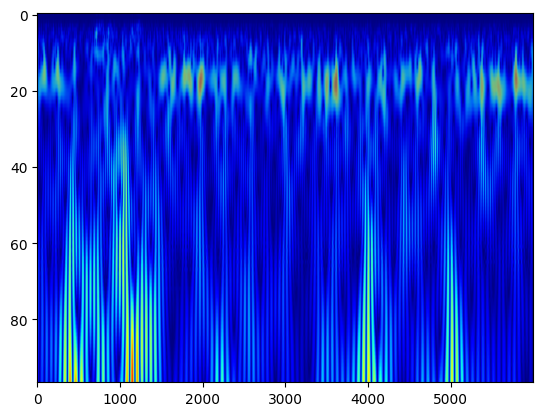

In [24]:
plt.imshow(rgb_array,aspect='auto')

In [16]:
cfs.shape

(97, 6000)

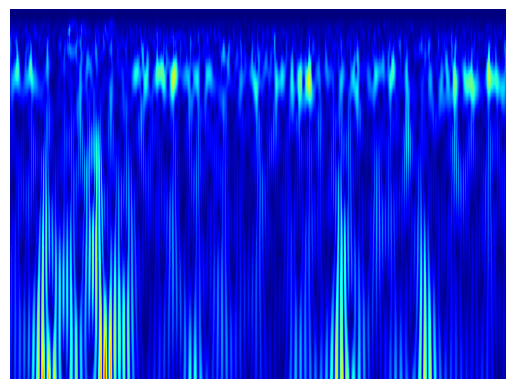

In [19]:
plt.imshow(abs(cfs) ,aspect='auto', cmap='jet')
plt.axis('off')
plt.savefig('plot.png', bbox_inches='tight')
img= Image.open("plot.png")
np_img = np.array(img)

In [ ]:
from io import BytesIO

# Create the plot
plt.imshow(abs(cfs), aspect='auto', cmap='jet')
plt.axis('off')

# Use BytesIO to capture the plot data in memory
buffer = BytesIO()
plt.savefig(buffer, format='png', bbox_inches='tight')

# Load the plot data from the buffer into a NumPy array
np_img = np.array(Image.open(buffer))

# Close the buffer (optional)
buffer.close()

# Print the array shape (for confirmation)
print(np_img.shape)

In [10]:
np_img.shape

(389, 515, 4)

In [37]:

# Specify the path to the .rec file
rec_file_path = r"1\1.rec"

# Open the .rec file
f = pyedflib.EdfReader(rec_file_path)

# # Get the number of signals in the .rec file
# num_signals = f.signals_in_file

# # Get the signal labels
# signal_labels = f.getSignalLabels()

# # Read the signals
# signals = []
# for i in range(num_signals):
#     signal = f.readSignal(i)
#     signals.append(signal)
input_signal = f.readSignal(6)

# Close the .rec file
f.close()


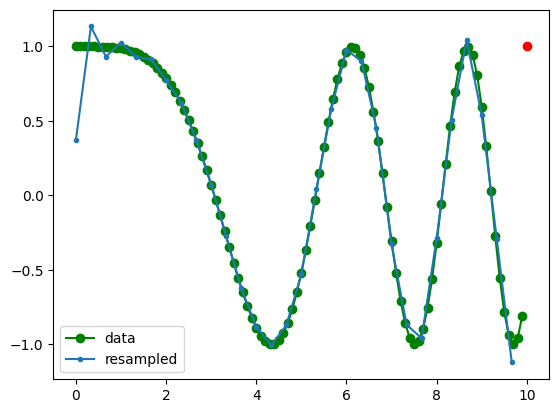

In [5]:

x = np.linspace(0, 10, 100, endpoint=False)
y = np.cos(-x**2/6.0)
f = signal.resample(y, 30)
xnew = np.linspace(0, 10, 30, endpoint=False)


import matplotlib.pyplot as plt
plt.plot(x, y, 'go-', xnew, f, '.-', 10, y[0], 'ro')
plt.legend(['data', 'resampled'], loc='best')
plt.show()